In [125]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
import matplotlib.pyplot as plt

In [126]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def tanh(z):
    return np.tanh(z)

def relu(z):
    return np.maximum(0, z)

In [127]:
# Neural network with multiple outputs for a system of differential equations
def neural_network(params, x):

    w_hidden = params[0]
    w_output = params[1]

    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    x_input = np.concatenate((np.ones((1, num_values)), x), axis=0)

    # Hidden layer
    z_hidden = np.matmul(w_hidden, x_input)
    x_hidden = relu(z_hidden)

    # Add bias term to hidden layer
    x_hidden = np.concatenate((np.ones((1, num_values)), x_hidden), axis=0)

    # Output layer (now with multiple outputs for the system of equations)
    z_output = np.matmul(w_output, x_hidden)
    
    return z_output  # Shape: (number_of_equations, num_values)


In [128]:
# Trial solution generalized for a system of equations
def g_trial(x, params, g0):
    # g0 should now be a vector (one value for each equation)
    return g0[:, np.newaxis] + (x) * neural_network(params, x)

In [129]:
def g(x, g_trial):
    # Example system: Modify this to match the system you're solving
    g1 =  g_trial[1]                      # First equation
    g2 = -3*g_trial[1] - 2 * g_trial[0]   # Second equation

    return np.array([g1, g2])

In [130]:
def cost_function(P, x, g0):
    g_t = g_trial(x, P, g0)

    # Find the derivative w.r.t x of the trial function
    d_g_t = elementwise_grad(g_trial, 0)(x, P, g0)

    # Print for debugging
    #print("g_trial:", g_t)
    #print("d_g_t (gradient of g_trial):", d_g_t)

    # The right side of the system of ODEs
    func = g(x, g_t)

    # Print the right-hand side of the system for debugging
    #print("Right-hand side (g):", func)

    err_sqr = (d_g_t - func) ** 2
    cost_sum = np.sum(err_sqr)

    return cost_sum / np.size(err_sqr)


In [131]:
# Solving system of ODEs with neural network
def solve_ode_neural_network(x, num_neurons_hidden, num_iter, lmb, g0):
    
    #p0 = npr.randn(num_neurons_hidden, 2)
    #p1 = npr.randn(2, num_neurons_hidden + 1)  # 2 equations, hence 2 output neurons
    
    p0 = npr.uniform(low=-0.1, high=0.1, size=(num_neurons_hidden, 2))
    p1 = npr.uniform(low=-0.1, high=0.1, size=(2, num_neurons_hidden + 1))  # For the output layer

    P = [p0, p1]
    

    print('Initial cost: %g' % cost_function(P, x, g0))

    cost_function_grad = grad(cost_function, 0)

    for i in range(num_iter):
        cost_grad = cost_function_grad(P, x, g0)

        P[0] -= lmb * cost_grad[0]
        P[1] -= lmb * cost_grad[1]

        if i % 1000 == 0:
            print(f'Iteration {i}, Cost: {cost_function(P, x, g0)}')

    print('Final cost: %g' % cost_function(P, x, g0))
    return P


In [132]:
# Analytical solutions for comparison (modify based on your system)
def g_analytic(x):
    g1 =  3*np.exp(-x) - 2*np.exp(-2*x)
    g2 = -3*np.exp(-x) + 4*np.exp(-2*x)  # Example second solution
    return np.array([g1, g2])

In [133]:
if __name__ == '__main__':
    npr.seed(15)

    N = 10
    x = np.linspace(0, 1, N)

    num_hidden_neurons = 10
    num_iter = 50000
    lmb = 0.0001

    g0 = np.array([1, 1])  # Initial conditions for the system of ODEs

    P = solve_ode_neural_network(x, num_hidden_neurons, num_iter, lmb, g0)

    res = g_trial(x, P, g0)
    res_analytical = g_analytic(x)

    print('Max absolute difference: %g' % np.max(np.abs(res - res_analytical)))


Initial cost: 13.9319
Iteration 0, Cost: 13.906271195487614
Iteration 1000, Cost: 4.67133412412018
Iteration 2000, Cost: 4.024127938969072
Iteration 3000, Cost: 3.9021192858325904
Iteration 4000, Cost: 3.808593814451373
Iteration 5000, Cost: 3.7193776889703685
Iteration 6000, Cost: 3.6311224178208255
Iteration 7000, Cost: 3.5400071508993682
Iteration 8000, Cost: 3.4608867569258153
Iteration 9000, Cost: 3.372426027770692
Iteration 10000, Cost: 3.320808121260948
Iteration 11000, Cost: 3.2478431502210023
Iteration 12000, Cost: 3.1362570627085598
Iteration 13000, Cost: 3.0963338984805193
Iteration 14000, Cost: 3.0229661032457242
Iteration 15000, Cost: 2.9058139500946547
Iteration 16000, Cost: 2.8345942881685273
Iteration 17000, Cost: 2.748194527625789
Iteration 18000, Cost: 2.761363955564503
Iteration 19000, Cost: 2.7084612040865146
Iteration 20000, Cost: 2.6051720236115585
Iteration 21000, Cost: 2.564218041808825
Iteration 22000, Cost: 2.5298610130969186
Iteration 23000, Cost: 2.495869227

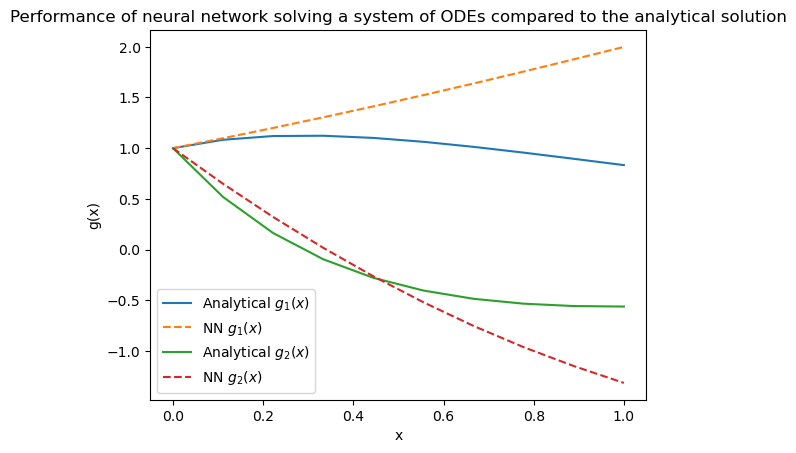

In [134]:
plt.title('Performance of neural network solving a system of ODEs compared to the analytical solution')
plt.plot(x, res_analytical[0], label='Analytical $g_1(x)$')
plt.plot(x, res[0, :], '--', label='NN $g_1(x)$')
plt.plot(x, res_analytical[1], label='Analytical $g_2(x)$')
plt.plot(x, res[1, :], '--', label='NN $g_2(x)$')
plt.legend()
plt.xlabel('x')
plt.ylabel('g(x)')
plt.show()